# **Imports**

In [1]:
# Common
import os
import keras
import numpy as np
from tqdm import tqdm
import cv2 as cv
from glob import glob
import tensorflow as tf

# Data 
from keras.preprocessing.image import img_to_array, array_to_img
import tensorflow.keras.layers as tfl
# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras import Sequential
from keras.layers import Conv2D, Conv2DTranspose, InputLayer, Layer, Input, Dropout, MaxPool2D, concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# **Data**

In [2]:
!git clone https://github.com/SrikantShubam/dataset.git data

Cloning into 'data'...
remote: Enumerating objects: 3484, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3484 (delta 0), reused 3 (delta 0), pack-reused 3481
Receiving objects: 100% (3484/3484), 100.32 MiB | 37.66 MiB/s, done.
Checking out files: 100% (6951/6951), done.


In [3]:
path = '/content/data/cityscapes_data/train/'
image_paths = sorted(glob(path + "*.jpg"))
SIZE = 160
images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

for i in tqdm(range(len(image_paths))):
    path = image_paths[i]
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = img_to_array(image).astype('float')
    img = image[:,:256,:]/255.0
    img = tf.image.resize(img,(SIZE, SIZE))
    mask = image[:,256:,:]/255.0
    mask = tf.image.resize(mask,(SIZE, SIZE))
    images[i] = img
    masks[i] = mask

100%|██████████| 2975/2975 [00:31<00:00, 93.16it/s] 


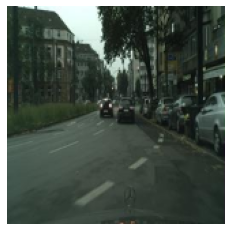

In [4]:
plt.imshow(images[45])
plt.axis('off')
plt.show()

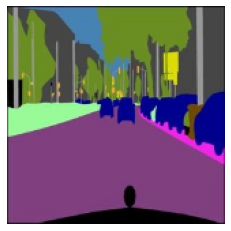

In [5]:
plt.imshow(masks[45])
plt.axis('off')
plt.show()

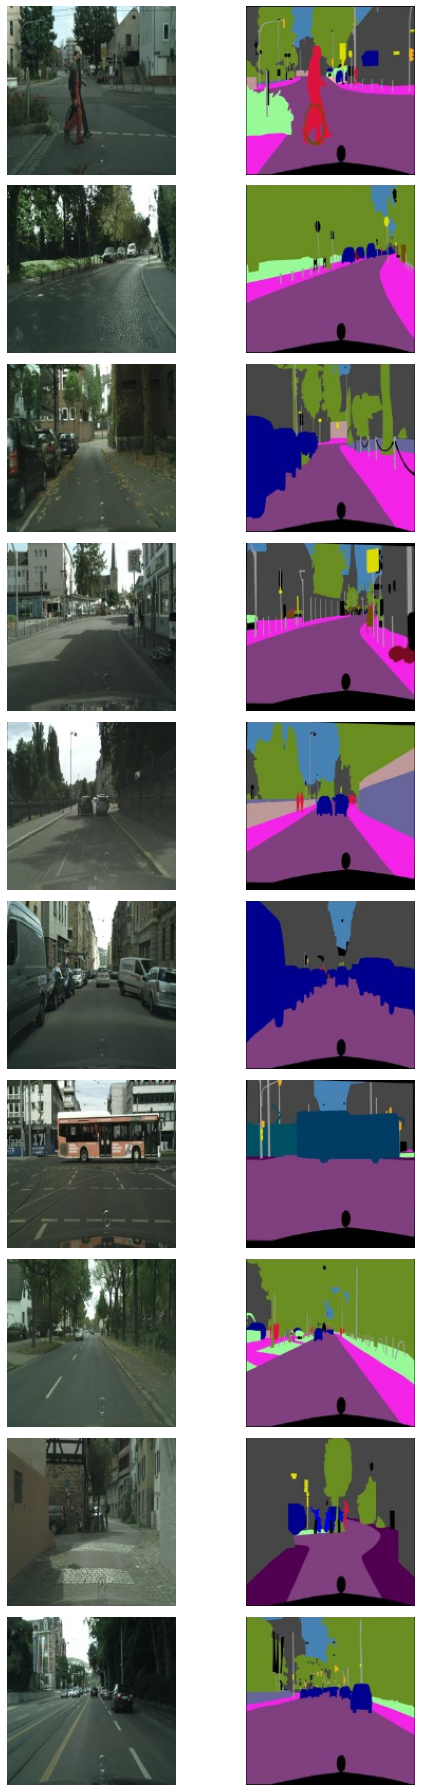

In [6]:
plt.figure(figsize=(8,25))
for i in range(1,21):
  plt.subplot(10,2,i)
  if i%2!=0:
    id = np.random.randint(len(images))
    image = images[id]
    plt.imshow(image)
    plt.axis('off')
  elif i%2==0:
    mask = masks[id]
    plt.imshow(mask)
    plt.axis('off')  
plt.tight_layout()
plt.show()

In [7]:
X_train, y_train = images[:2900], masks[:2900]
X_valid, y_valid = images[2900:], masks[2900:]

# **UNet Autoencoder**

In [8]:
# Encoder Layer Block
class EncoderLayerBlock(Layer):
  def __init__(self, filters, rate, pooling=True):
    super(EncoderLayerBlock, self).__init__()
    self.filters = filters
    self.rate = rate
    self.pooling = pooling

    self.c1 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
    self.drop = Dropout(self.rate)
   
    self.c2 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
    self.BatchNormalization= tfl.BatchNormalization()
    self.relu=tfl.LeakyReLU()
    self.pool = MaxPool2D(pool_size=(2,2))
   

  def call(self, X):
    x = self.c1(X)
    x = self.drop(x)
    x = self.c2(x)
    if self.pooling:
      y = self.pool(x)
      return y, x
    else: 
      return x

  def get_config(self):
    base_estimator = super().get_config()
    return {
        **base_estimator,
        "filters":self.filters,
        "rate":self.rate,
        "pooling":self.pooling
    }

#  Decoder Layer
class DecoderLayerBlock(Layer):
  def __init__(self, filters, rate, padding='same'):
    super(DecoderLayerBlock, self).__init__()
    self.filters = filters
    self.rate = rate
    self.cT = Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding=padding)
    self.next = EncoderLayerBlock(self.filters, self.rate, pooling=False)

  def call(self, X):
    X, skip_X = X
    x = self.cT(X)
    c1 = concatenate([x, skip_X])
    y = self.next(c1)
    return y 

  def get_config(self):
    base_estimator = super().get_config()
    return {
        **base_estimator,
        "filters":self.filters,
        "rate":self.rate,
    }

#  Callback 
class ShowProgress(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(X_valid))
    rand_img = X_valid[id][np.newaxis,...]
    pred_mask = self.model.predict(rand_img)[0]
    true_mask = y_valid[id]

    
    plt.subplot(1,3,1)
    plt.imshow(rand_img[0])
    plt.title("Original Image")
    plt.axis('off')
    

    plt.subplot(1,3,2)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(true_mask)
    plt.title("True Mask")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [9]:
with tf.device('/GPU:0'):
    # Input Layer 
    input_layer = Input(shape=X_train.shape[-3:])

    # Encoder
    p1, c1 = EncoderLayerBlock(16,0.1)(input_layer)
    p2, c2 = EncoderLayerBlock(32,0.1)(p1)
    p3, c3 = EncoderLayerBlock(64,0.2)(p2)
    p4, c4 = EncoderLayerBlock(128,0.2)(p3)
    conv = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv1')(input_layer)
    x=tfl.BatchNormalization()(conv)
    x=tfl.LeakyReLU()(x)
    x1 = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv2')(
        x)
    x=tfl.BatchNormalization()(x1)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)
    # Encoding Layer
    c5 = EncoderLayerBlock(256,0.3,pooling=False)(p4)
    
    conv = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv1')(
        input_layer)
    x=tfl.BatchNormalization()(conv)
    x=tfl.LeakyReLU()(x)
    x1 = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv2')(
        x)
    x=tfl.BatchNormalization()(x1)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)

    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv3')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x2 = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv4')(x)
    x=tfl.BatchNormalization()(x2)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), name='MaxPool2')(x)

    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv5')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x3 = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv6')(x)
    x=tfl.BatchNormalization()(x3)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool3')(x)

    
    x = tfl.Conv2D(256, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv7')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x3], axis=3)
    
    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv9')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv10')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x2], axis=3)
    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv11')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv12')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x1], axis=3)

    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv25')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv26')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)



    # Decoder
    d1 = DecoderLayerBlock(128,0.2)([c5, c4])
    d2 = DecoderLayerBlock(64,0.2)([d1, c3])
    d3 = DecoderLayerBlock(32,0.2)([d2, c2])
    d4 = DecoderLayerBlock(16,0.2)([d3, c1])
   
    # Output layer
    output = Conv2D(3,kernel_size=1,strides=1,padding='same',activation='softmax')(x)

    # U-Net Model
    model = keras.models.Model(
        inputs=[input_layer],
        outputs=[output],
    )

    # Compiling
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2)]
    )

    # Callbacks 
    callbacks =[
        
        ModelCheckpoint("UNet-Colorizer.h5", save_best_only=True),
        ShowProgress()
    ]

   

In [10]:
def build_model(inputsize=(256,256,3),classes=None):
    inputs = tf.keras.Input(shape=(inputsize))

    conv = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv1')(
        inputs)
    x=tfl.BatchNormalization()(conv)
    x=tfl.LeakyReLU()(x)
    x1 = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv2')(
        x)
    x=tfl.BatchNormalization()(x1)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)

    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv3')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x2 = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv4')(x)
    x=tfl.BatchNormalization()(x2)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), name='MaxPool2')(x)

    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv5')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x3 = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv6')(x)
    x=tfl.BatchNormalization()(x3)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool3')(x)

    
    x = tfl.Conv2D(256, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv7')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(256, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv8')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x3], axis=3)
    
    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv9')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv10')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x2], axis=3)

    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv11')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv12')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x1], axis=3)

    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv25')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv26')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    outputs = tfl.Conv2D(classes, (1, 1), padding="same", activation='relu', name='Outputs')(x)
    final_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    final_model.summary()
    return final_model

In [11]:
mymodel=build_model(classes=2)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_27 (BatchN  (None, 256, 256, 32  128        ['Conv1[0][0]']                  
 ormalization)                  )                                                           

In [12]:
 # Train The Model
history=model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=200,
        callbacks=callbacks
    )

Output hidden; open in https://colab.research.google.com to view.

This model architecture is famously known for its segmentation abilities and In this image data set it does its job. The model seems to lose some of the spatial information. This is because of the smaller size of the input images. I found something wrong with these true mask images. Which I used for validation purpose. 

# **Evaluation**

In [13]:
path = '/content/data/cityscapes_data/trainval/'
image_paths = sorted(glob(path + "*.jpg"))
SIZE = 160
images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

for i in tqdm(range(len(image_paths))):
    path = image_paths[i]
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = img_to_array(image).astype('float')
    img = image[:,:256,:]/255.0
    img = tf.image.resize(img,(SIZE, SIZE))
    mask = image[:,256:,:]/255.0
    mask = tf.image.resize(mask,(SIZE, SIZE))
    images[i] = img
    masks[i] = mask

0it [00:00, ?it/s]


In [14]:
def show_image(image,title=None):
    plt.imshow(image)
    if title is not None: plt.title(title)
    plt.axis('off')

ValueError: ignored

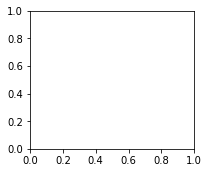

In [15]:
plt.figure(figsize=(10,30))
n=0
for i in range(1,31):
    plt.subplot(10,3,i)
    if n==0:
        id = np.random.randint(len(images))
        real_img = images[id][np.newaxis,...]
        pred_mask = model.predict(real_img)[0]
        mask = masks[id]
        show_image(real_img[0], title="Real Image")
        n+=1
    elif n==1:
        show_image(pred_mask, title="Predicted Mask")
        n+=1
    elif n==2:
        show_image(mask, title="Original Mask")
        n=0
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss')
plt.legend()

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()